
# Regresión Lineal con datos agrícolas — **versión explicada paso a paso**

En este cuaderno predecimos **`Producción_Ton`** usando solo **Regresión Lineal** con scikit‑learn.
Cada paso incluye una explicación breve (qué, por qué y cómo), buenas prácticas y advertencias comunes.



## Paso 0 · Requisitos y archivo de datos
- **Archivo**: `1. datos_agricolas.xlsx`, hoja **`Inicio`** (debe estar en la misma carpeta del notebook, o actualiza la ruta).
- **Librerías**: `pandas`, `scikit-learn`, `matplotlib`, `openpyxl` (para leer Excel).
- **Objetivo**: predecir `Producción_Ton` SIN usar `Ingresos` ni `Utilidad` para evitar **fuga de información**.



## Paso 1 · Importar librerías (¿qué y por qué?)
- `pandas` para manejar dataframes.
- `train_test_split` para separar entrenamiento/prueba (evita sobreajuste y mide generalización).
- `ColumnTransformer`/`Pipeline` para **empaquetar** preprocesamiento + modelo (reproducible y limpio).
- `OneHotEncoder` para convertir variables categóricas (`Región`, `Cultivo`) a números.
- `StandardScaler` para escalar numéricas (útil para muchos modelos; no daña a la regresión lineal).
- Métricas: `MAE`, `MSE/RMSE`, `R2` para evaluar precisión.


In [3]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt



## Paso 2 · Cargar los datos (¿cómo validar que cargó bien?)
- Usamos `read_excel` indicando la hoja `Inicio`.
- Revisamos `head()` para ver las primeras filas y confirmar nombres de columnas.


In [4]:

# 🔁 Ajusta la ruta si no estás ejecutando este notebook en ChatGPT
file_path = "1. datos_agricolas.xlsx"  # Ejemplo: "1. datos_agricolas.xlsx"

df = pd.read_excel(file_path, sheet_name="Inicio")
df.head()


,Año,Mes,Región,Cultivo,Superficie_Ha,Producción_Ton,Precio_Ton,Costos_Insumos,Ingresos,Utilidad
0,2023,7,Sur,Manzana,34,4583,377.65,5267,1730769.95,1725502.95
1,2024,5,Centro,Tomate,253,3501,106.45,6988,372681.45,365693.45
2,2023,3,Sur,Soja,430,716,249.06,9680,178326.96,168646.96
3,2023,3,Sur,Soja,37,3074,240.68,2485,739850.32,737365.32
4,2023,4,Norte,Maíz,462,763,317.39,15713,242168.57,226455.57



## Paso 3 · Exploración breve (EDA) (¿qué mirar?)
- `df.info()` para tipos de datos y nulos.
- `describe()` para rangos, medias y posibles outliers.
- Verifica que las columnas relevantes existan y tengan sentido.


In [5]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Año             1800 non-null   int64  
 1   Mes             1800 non-null   int64  
 2   Región          1800 non-null   object 
 3   Cultivo         1800 non-null   object 
 4   Superficie_Ha   1800 non-null   int64  
 5   Producción_Ton  1800 non-null   int64  
 6   Precio_Ton      1800 non-null   float64
 7   Costos_Insumos  1800 non-null   int64  
 8   Ingresos        1800 non-null   float64
 9   Utilidad        1800 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 140.8+ KB


In [6]:

df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Año,1800.0,NaN,NaN,NaN,2023.493889,0.500102,2023.0,2023.0,2023.0,2024.0,2024.0
Mes,1800.0,NaN,NaN,NaN,6.471111,3.450797,1.0,3.75,6.0,9.0,12.0
Región,1800,3,Norte,638,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cultivo,1800,7,Manzana,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Superficie_Ha,1800.0,NaN,NaN,NaN,246.046111,143.402285,5.0,119.75,241.0,372.0,499.0
Producción_Ton,1800.0,NaN,NaN,NaN,2500.136111,1440.965374,22.0,1226.0,2478.0,3782.5,4999.0
Precio_Ton,1800.0,NaN,NaN,NaN,294.1675,114.812603,100.1,194.3575,290.56,391.5875,499.68
Costos_Insumos,1800.0,NaN,NaN,NaN,10463.516667,5543.629521,1015.0,5637.5,10454.5,15283.0,19996.0
Ingresos,1800.0,NaN,NaN,NaN,730882.352328,532210.614766,3903.76,299830.0575,619911.25,1054964.955,2449579.37
Utilidad,1800.0,NaN,NaN,NaN,720418.835661,532189.137805,-6486.34,288587.88,609028.41,1044912.85,2430133.37



## Paso 4 · Selección de variables y **split** (¿por qué así?)
- **Objetivo (y):** `Producción_Ton`.
- **Predictores (X):** `Año`, `Mes`, `Región`, `Cultivo`, `Superficie_Ha`, `Precio_Ton`, `Costos_Insumos`.
- **Buenas prácticas:** no usar `Ingresos`/`Utilidad` porque derivan de `Producción_Ton` → **data leakage**.
- **Split 80/20** con `random_state=42` para reproducibilidad.


In [7]:

target_col = "Producción_Ton"
feature_cols = ["Año", "Mes", "Región", "Cultivo", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(1440, 360)


## Paso 5 · Preprocesamiento con `ColumnTransformer` (¿qué hace cada etapa?)
- **Numéricas** (`Año`, `Mes`, `Superficie_Ha`, `Precio_Ton`, `Costos_Insumos`):
  - `SimpleImputer(strategy="median")`: rellena nulos de forma robusta.
  - `StandardScaler()`: centra y escala (media 0, desvío 1).
- **Categóricas** (`Región`, `Cultivo`):
  - `SimpleImputer(strategy="most_frequent")`: rellena nulos con la moda.
  - `OneHotEncoder(handle_unknown="ignore")`: convierte categorías a dummies y evita errores con categorías nuevas.
- Esto evita fugas desde `test` hacia `train` porque el ajuste se hace **dentro** del pipeline.


In [8]:

numeric_features = ["Año", "Mes", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
categorical_features = ["Región", "Cultivo"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



## Paso 6 · Entrenar **Regresión Lineal** (¿por qué en pipeline?)
- El `Pipeline` garantiza que **las mismas transformaciones** se apliquen en entrenamiento y predicción.
- La regresión lineal aprende coeficientes para cada feature (tras one‑hot y escalado).


In [9]:

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)



## Paso 7 · Evaluación del modelo (¿cómo interpretar métricas?)
- **MAE**: error absoluto medio, en toneladas (más bajo es mejor).
- **RMSE**: raíz del MSE; penaliza más errores grandes (más bajo es mejor).
- **R²**: proporción de varianza explicada (cercano a 1 es mejor; negativo = peor que predecir la media).


In [10]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.3f}")


MAE: 1239.58
RMSE: 1442.66
R2: -0.004



## Paso 8 · Visualización **Predicho vs Real** (¿qué buscamos?)
- La línea diagonal representa la **predicción perfecta**.
- Puntos cerca de la línea → buena predicción; dispersión grande → el modelo no captura bien ciertos casos.
- Si notas patrón curvo o abanico, puede haber **no linealidad** o **heterocedasticidad** (quizás otro modelo o features derivadas ayuden).


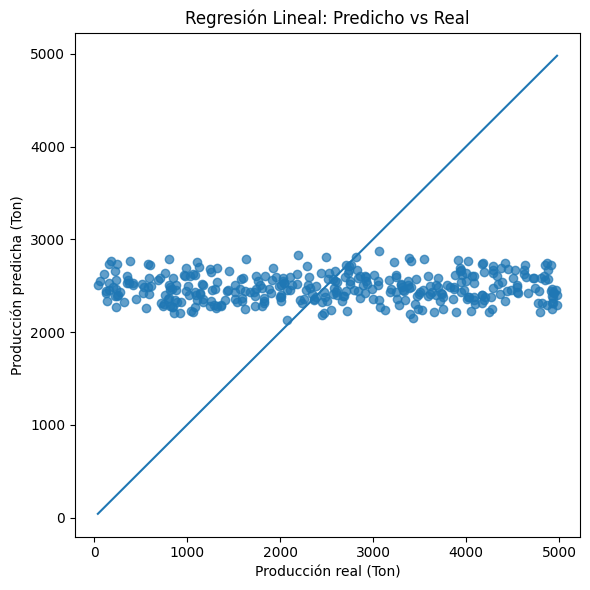

In [11]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Producción real (Ton)")
plt.ylabel("Producción predicha (Ton)")
plt.title("Regresión Lineal: Predicho vs Real")
plt.tight_layout()
plt.show()



## Paso 9 · (Opcional) Coeficientes interpretables
- Podemos ver la **magnitud y signo** de cada coeficiente tras el one‑hot/escala.
- Ojo: la interpretación exacta depende del **escalado** y de la **codificación**.


In [12]:

# Recuperar nombres de columnas transformadas
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = list(ohe.get_feature_names_out(["Región", "Cultivo"]))
num_names = ["Año", "Mes", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
feature_names = num_names + cat_names

linreg = model.named_steps["model"]
coefs = pd.Series(linreg.coef_, index=feature_names).sort_values(ascending=False)
coefs.head(15)


Cultivo_Manzana    153.517078
Cultivo_Trigo      103.009202
Región_Norte        96.602787
Cultivo_Tomate      67.916511
Año                 -2.294440
Cultivo_Soja       -12.606658
Región_Sur         -26.927158
Superficie_Ha      -29.382114
Cultivo_Uva        -32.762297
Mes                -34.074669
Precio_Ton         -37.520560
Costos_Insumos     -45.161173
Región_Centro      -69.675629
Cultivo_Maíz      -125.737871
Cultivo_Papa      -153.335964
dtype: float64


## Paso 10 · Siguientes pasos recomendados
1. **Ingeniería de variables**: por ejemplo, estacionalidad (trimestre), interacciones `Región×Cultivo`, o logs si hay asimetrías.
2. **Validación cruzada**: evaluar estabilidad del R² y errores.
3. **Diagnóstico**: revisar residuos (`y_real - y_pred`) para detectar sesgos.
4. **Comparar** (en otro cuaderno) con modelos no lineales si la lineal no captura todo.
